# Юнит 6. Предсказание стоимости автомобиля
## Цель: по данным автомобиля предсказать его стоимость

**Команда проекта** (в алфавитном порядке):

- Мишина Дарья
- Никишин Андрей
- Румянцев Иван

**Дано:**

- Дата сет с параметрами автомобилей BMW, из регионов Москва и Московская область, без цен.

**План работы:**

- Собрать дата сет для обучения модели.
- Провести предобработку данных, анализ и создание/удаление признаков (EDA).
- Провести выбор моделей для обучения.
- Подобрать гиперпараметры моделей.
- Объединить модели в стек для получения оптимального результата.
- На этапах тестирования использовать кросс-валидацию.

## Собрать дата сет для обучения модели
### Идея
"Спарсить" несколько датасетов с auto.ru:
- BMW центральный регион.
- BMW центральный регион + другие регионы.

**Если результаты будут плохими и/или останется время:**
- BMW + другие марки, центральный регион.
- BMW + другие марки, центральный регион + другие регионы.

Сравнить на каком датасете модель обучается лучше.

### !!! *Здесь вставить описание Ивана, как парсили*

## Загрузим библиотеки

### !!! *Проверить, все ли необходимые библиотеки загружены, нет ли лишних*

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import sys
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Используемые в работе функции

### Построение диаграмм и графиков

In [2]:
# Графики для числовых параметров
def get_gr_num(df, col, bns=10):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")

    sns.distplot(df[col], bins=bns)
    axes.set_title(col)

In [3]:
# Количество
def get_gr_counts(df, col):
    print('Признак ', col)
    print()
    print(df[col].value_counts())
    print()
    print()
    df[col].value_counts(ascending=True).plot(
        kind='barh', title=col, cmap='coolwarm')

### Обработка признаков

In [4]:
# Обработка признака 'name'
def get_model_from_name(string):
    string = string.replace(' 4WD', '')
    s_list = string.split(' ')
    n = len(s_list)
    if n == 7:
        return str(s_list[0])+str(s_list[1])+str(s_list[2])
    elif n == 6:
        return str(s_list[0])+str(s_list[1])
    elif n == 5:
        return str(s_list[0])
    else:
        return None

## Исходные данные

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
VERSION = 20200905

# подключил к ноутбуку свой внешний датасет auto_ru_05092020_BMW_4_districts.csv
DIR_TRAIN = '../input/train10092020/'
DIR_TEST = '../input/sf-dst-car-price/'
VAL_SIZE = 0.33   # 33%
N_FOLDS = 5

# CATBOOST
ITERATIONS = 2000
LR = 0.1

In [7]:
!ls ../input/

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [8]:
# выведем побольше колонок и строк
max_columns = 30
max_rows = 30
pd.set_option('display.max_columns', max_columns)
pd.set_option('display.max_rows', max_rows)

In [9]:
# #это для кэгла, загрузка из input
# train = pd.read_csv(DIR_TRAIN+'auto_ru_05092020_BMW_4_districts.csv') # подготовленный датасет для обучения модели
# test = pd.read_csv(DIR_TEST+'test.csv')
# sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [10]:
# # #это загрузка с моего компа
# train = pd.read_csv(
#     '/Users/dariamishina/Documents/Skillfactory/ML Daria/RDS_drafts/sf_module_5/from git/auto_ru_05092020_BMW_4_districts.csv')
# test = pd.read_csv(
#     '/Users/dariamishina/Documents/Skillfactory/ML Daria/RDS_drafts/sf_module_5/from git/test.csv')
# sample_submission = pd.read_csv(
#     '/Users/dariamishina/Documents/Skillfactory/ML Daria/RDS_drafts/sf_module_5/from git/sample_submission.csv')

In [11]:
# Это загрузка с компа Андрей
# подготовленный датасет для обучения модели
train = pd.read_csv('auto_ru_05092020_BMW_4_districts.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## Провести предобработку данных, анализ и создание/удаление признаков (EDA)

In [12]:
test.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \r\n\r\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [13]:
train.head(5)

,district_id,region_id,bodyType,brand,model,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price
0,3,10687,Хэтчбек 5 дв.,BMW,1ER,040001,бензин,2011,116i 1.6 AT (136 л.с.),5,2012,AUTOMATIC,116i,136,NaN,78000,"{'id': '7707468', 'name': '116i', 'available_o...",задний,LEFT,3.0,ORIGINAL,True,"{'year': 2017, 'month': 8}",570000.0
1,3,10687,Седан,BMW,3ER,0000CC,дизель,2011,320d xDrive 2.0d AT (184 л.с.) 4WD,4,2014,AUTOMATIC,320d,184,"Полностью обслужена ,покрыта керамикой, хороша...",86000,{'id': '0'},полный,LEFT,3.0,ORIGINAL,True,NaN,1150000.0
2,3,10687,Седан,BMW,3ER,22A0F8,бензин,2011,320i xDrive 2.0 AT (184 л.с.) 4WD,4,2014,AUTOMATIC,320i,184,"Авто в отличном состоянии, М-пакет, салон альк...",80000,{'id': '0'},полный,LEFT,2.0,ORIGINAL,True,NaN,1140000.0
3,3,10687,Седан,BMW,3ER,FAFBFB,бензин,2008,318i 2.0 AT (136 л.с.),4,2011,AUTOMATIC,318i,136,Устранены оснавные болячки. Заменён гидротранс...,156000,{'id': '0'},задний,LEFT,3.0,ORIGINAL,True,NaN,550000.0
4,3,10687,Седан,BMW,3ER,0000CC,бензин,2001,318i 2.0 AT (143 л.с.),4,2002,AUTOMATIC,318i,143,Авто в исправном состоянии есть недочёты по ку...,240350,{'id': '0'},задний,LEFT,3.0,ORIGINAL,True,NaN,250000.0


### Пропуски

In [14]:
# Смотрим на пропуски
train.isnull().sum()

district_id                 0
region_id                   0
bodyType                    0
brand                       0
model                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
engineDisplacement          0
enginePower                 0
description               532
mileage                     0
Комплектация                0
Привод                      0
Руль                        0
Владельцы                2756
ПТС                       197
Таможня                     0
Владение                12737
Price                      69
dtype: int64

In [15]:
# Смотрим на пропуски
test.isnull().sum()

bodyType                   0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
engineDisplacement         0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
Владение                2084
id                         0
dtype: int64

**Отметим, где были пропуски и выделим это в отдельный признак**

Создаем одинаковые признаки в двух датасетах, для их последующего объединения

In [16]:
train['description_Nan'] = pd.isna(train['description']).astype('uint8')
train['owners_Nan'] = pd.isna(train['Владельцы']).astype('uint8')
train['pts_Nan'] = pd.isna(train['ПТС']).astype('uint8')
# train['own_date_Nan'] = pd.isna(train['Владение']).astype('uint8') # Этот признак в итоге был удален, подтому индекатор закомментировали

test['description_Nan'] = pd.isna(test['description']).astype('uint8')
test['owners_Nan'] = pd.isna(test['Владельцы']).astype('uint8')
test['pts_Nan'] = pd.isna(test['ПТС']).astype('uint8')
# test['own_date_Nan'] = pd.isna(test['Владение']).astype('uint8') # Этот признак в итоге был удален, подтому индекатор закомментировали

### Целевая переменная
**Посмотрим на признак 'Price'**

*Во всех предварительных тестах данный признак мы пишем со строчной буквы.*

- Сразу переименуем его в 'price'.
- Удалим строки с пропусками.
- Поменяем тип на 'int' для правильной работы классификатора 'Cat boost'.

In [17]:
train.rename(columns={'Price': 'price'}, inplace=True)
train = train.dropna(subset=['price'], axis=0)
train['price'] = train['price'].astype('int64')

**Посмотрим распределение целевой переменной**

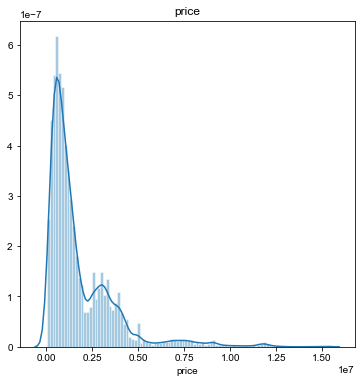

In [18]:
get_gr_num(train, 'price', 100)

**Предварительный вывод:** Целевую переменную следует логарифмировать.

## Сравним признаки в train и test
И приведем их в соответствие друг другу для последующего объединения датасетов

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17555 entries, 0 to 17623
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_id           17555 non-null  int64  
 1   region_id             17555 non-null  int64  
 2   bodyType              17555 non-null  object 
 3   brand                 17555 non-null  object 
 4   model                 17555 non-null  object 
 5   color                 17555 non-null  object 
 6   fuelType              17555 non-null  object 
 7   modelDate             17555 non-null  int64  
 8   name                  17555 non-null  object 
 9   numberOfDoors         17555 non-null  int64  
 10  productionDate        17555 non-null  int64  
 11  vehicleConfiguration  17555 non-null  object 
 12  engineDisplacement    17555 non-null  object 
 13  enginePower           17555 non-null  int64  
 14  description           17026 non-null  object 
 15  mileage            

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

In [21]:
set(train.columns) - set(test.columns)

{'district_id', 'model', 'price', 'region_id'}

В **test** отсутствуют параметры: **'district_id', 'model', 'price', 'region_id'** - поработаем с ними.

In [22]:
# Добавим недостоющие столбцы для совместной обработки датасетов test & train
test['price'] = 0
test['district_id'] = 3  # Код Центрального федерального региона
test['region_id'] = 1  # Код Москвы и МО

Создадим признак **'model'**

In [23]:
test['model'] = test['name'].apply(get_model_from_name)
test['model']

0             520d
1             318d
2       550ixDrive
3              30d
4             M50d
           ...    
3832          520i
3833           30d
3834         525xi
3835    528ixDrive
3836           50i
Name: model, Length: 3837, dtype: object

Проведем обратную проверку признаков

In [24]:
set(test.columns) - set(train.columns)

{'id', 'vehicleTransmission', 'Состояние'}

В **train** отсутствуют параметры: **'id', 'vehicleTransmission', 'Состояние'**

Удалим признаки **'id'** и **'Состояние'**, т. к. они не несут уникальной информации.

In [25]:
test = test.drop(['Состояние', 'id'], axis=1)

### Посмотрим на признак 'vehicleTransmission'

Признак  vehicleTransmission

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64




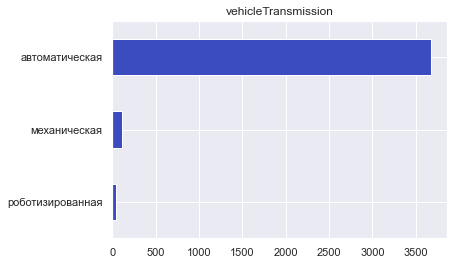

In [26]:
get_gr_counts(test, 'vehicleTransmission')

- Дальнейшая обработка данных показала, что данный признак дублирует информацию, существующую в других признаках. Удалим его, как избыточный.

In [27]:
test = test.drop(['vehicleTransmission'], axis=1)

### Признак 'bodyType'

Признак  bodyType

внедорожник 5 дв.    1626
седан                1594
купе                  214
хэтчбек 5 дв.         163
лифтбек               125
универсал 5 дв.        46
хэтчбек 3 дв.          36
кабриолет              19
родстер                10
компактвэн              3
седан 2 дв.             1
Name: bodyType, dtype: int64




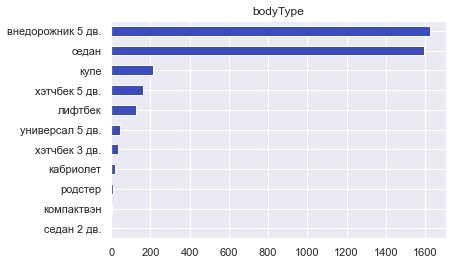

In [28]:
get_gr_counts(test, 'bodyType')

Признак  bodyType

Седан                     7828
Внедорожник 5 дв.         6780
Купе                       675
Седан Long                 547
Хэтчбек 5 дв.              541
Лифтбек Gran Turismo       348
Седан Gran Coupe           246
Универсал 5 дв.            178
Хэтчбек 3 дв.              128
Кабриолет                  112
Родстер                     49
Хэтчбек 3 дв. Compact       48
Седан 2 дв.                 27
Лифтбек Gran Coupe          23
Компактвэн Gran Tourer      10
Компактвэн                   7
Купе-хардтоп                 7
Родстер Roadster             1
Name: bodyType, dtype: int64




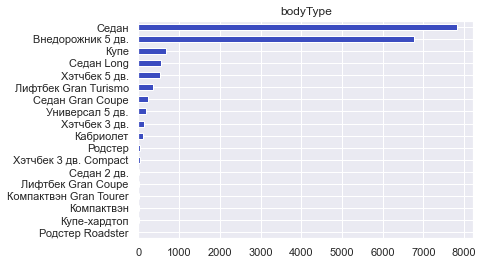

In [29]:
get_gr_counts(train, 'bodyType')

- Заменим в train названия на строчные буквы, как в test.

**Дальше есть несколько идей** будем их тестировать.

- Приведем в соответствие значения в train значениям в test
- Удалить из трейна то, чего нет в тесте (потеряем часть строк, но уберем то, чего нет в данных, на которых будем проверять модель, меньше мусора в процессе обучения).


In [30]:
# Заменим всё на строчные буквы
train['bodyType'] = train['bodyType'].apply(lambda x: x.lower())

In [31]:
filt = set(train['bodyType']) - set(test['bodyType'])
filt

{'компактвэн gran tourer',
 'купе-хардтоп',
 'лифтбек gran coupe',
 'лифтбек gran turismo',
 'родстер roadster',
 'седан gran coupe',
 'седан long',
 'хэтчбек 3 дв. compact'}

Создадим индикатор в train по отличающимся значениям, для последующей фильтрации.

In [32]:
train['filter_1'] = 0
test['filter_1'] = 0
train['filter_1'] = train['bodyType'].apply(lambda x: 1 if x in filt else 0)
train['filter_1'].value_counts()

0    16325
1     1230
Name: filter_1, dtype: int64

Приведем названия в train в соответствие с test

In [33]:
body_type_dict = {
    'компактвэн gran tourer': 'компактвэн',
    'купе-хардтоп': 'купе',
    'лифтбек gran coupe': 'лифтбек',
    'лифтбек gran turismo': 'лифтбек',
    'родстер roadster': 'родстер',
    'седан gran coupe': 'седан',
    'седан long': 'седан',
    'хэтчбек 3 дв. compact': 'хэтчбек 3 дв.'
}

train['bodyType'] = train['bodyType'].replace(to_replace=body_type_dict)

### Признак 'brand'
На первом этапе работаем только с BMW, поэтому признак не несет уникальной информации. Удалим его.

In [34]:
test = test.drop(['brand'], axis=1)
train = train.drop(['brand'], axis=1)

### Признак 'color'

Признак  color

040001    6858
FAFBFB    3301
97948F    2109
0000CC    2084
CACECB    1219
EE1D19     549
200204     480
007F00     350
C49648     161
22A0F8     148
DEA522     100
FF8649      80
660099      63
4A2197      42
FFD600       9
FFC0CB       2
Name: color, dtype: int64




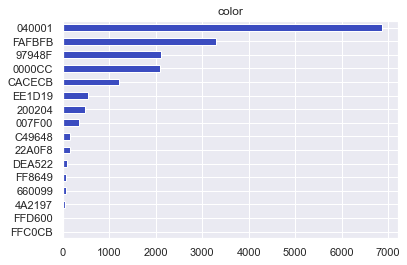

In [35]:
get_gr_counts(train, 'color')

Признак  color

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64




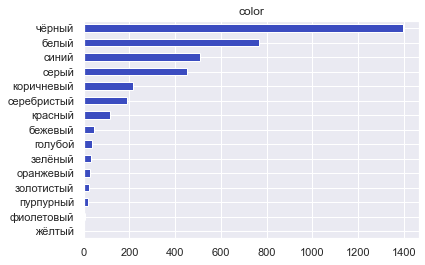

In [36]:
get_gr_counts(test, 'color')

Переведем технические сокращения цветов в человекопонятный вид в train

In [37]:
# замена цвета в train
hex_color = {
    '040001': 'чёрный',
    'FAFBFB': 'белый',
    '0000CC': 'синий',
    '97948F': 'серый',
    'CACECB': 'серебристый',
    '200204': 'коричневый',
    'EE1D19': 'красный',
    '007F00': 'зелёный',
    '22A0F8': 'голубой',
    'C49648': 'бежевый',
    'FF8649': 'оранжевый',
    'DEA522': 'золотистый',
    '4A2197': 'фиолетовый',
    '660099': 'пурпурный',
    'FFD600': 'жёлтый',
    'FFC0CB': 'розовый'
}

train['color'].replace(hex_color, inplace=True)

### Признак 'fuelType'

Признак  fuelType

бензин     11939
дизель      5561
гибрид        42
электро       13
Name: fuelType, dtype: int64




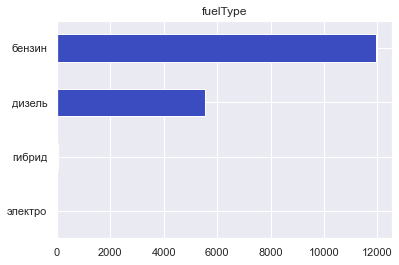

In [38]:
get_gr_counts(train, 'fuelType')

Признак  fuelType

бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64




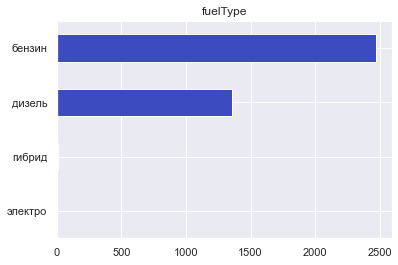

In [39]:
get_gr_counts(test, 'fuelType')

**Предварительный вывод:** Полностью соответствуют, обработка пока не требуется.

### Признак 'modelDate'
Год начала производства данной модели авто.
- Переведем тип данных в int.
- Попробовать логарифмировать признак.

Посмотрим на года моделей, которые есть в train, но отсутствуют в test. Варианты дальнейшей работы с этими данными:
- Удалить из трейна то, чего нет в тесте (потеряем часть строк, но уберем то, чего нет в данных, на которых будем проверять модель, меньше мусора в процессе обучения).
- Оставить признаки в трейне, как есть (сохранятся строки, и по этому признаку будет различие в выборках).

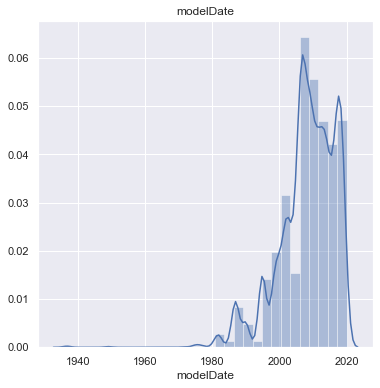

In [40]:
get_gr_num(train, 'modelDate', 30)

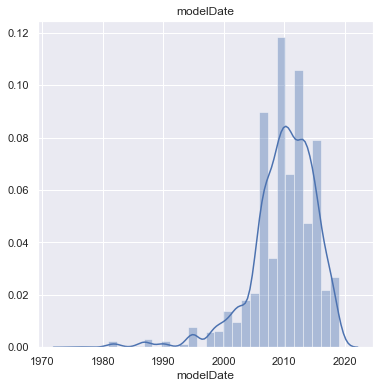

In [41]:
get_gr_num(test, 'modelDate', 30)

In [42]:
test['modelDate'] = test['modelDate'].astype('int64')
filt = set(train['modelDate']) - set(test['modelDate'])
filt

{1936, 1937, 1949, 1966, 1968, 1972, 1976, 1988, 1989, 1992, 1997, 2020}

Создадим индикатор в train по отличающимся значениям, для последующей фильтрации.

In [43]:
train['filter_2'] = 0
test['filter_2'] = 0
train['filter_2'] = train['modelDate'].apply(lambda x: 1 if x in filt else 0)
train['filter_2'].value_counts()

0    17301
1      254
Name: filter_2, dtype: int64

### Признак 'name'
В признаке очень много информации различных типов. Вытащим её в отдельные признаки.

In [44]:
train['d_in_name'] = train['name'].apply(lambda x: 1 if 'd' in x else 0)
test['d_in_name'] = test['name'].apply(lambda x: 1 if 'd' in x else 0)

train['i_in_name'] = train['name'].apply(lambda x: 1 if 'i' in x else 0)
test['i_in_name'] = test['name'].apply(lambda x: 1 if 'i' in x else 0)

train['4WD_in_name'] = train['name'].apply(lambda x: 1 if '4WD' in x else 0)
test['4WD_in_name'] = test['name'].apply(lambda x: 1 if '4WD' in x else 0)

train['xDrive_in_name'] = train['name'].apply(
    lambda x: 1 if 'xDrive' in x else 0)
test['xDrive_in_name'] = test['name'].apply(
    lambda x: 1 if 'xDrive' in x else 0)

train['xi_in_name'] = train['name'].apply(lambda x: 1 if 'xi' in x else 0)
test['xi_in_name'] = test['name'].apply(lambda x: 1 if 'xi' in x else 0)

train['L_in_name'] = train['name'].apply(lambda x: 1 if 'L' in x else 0)
test['L_in_name'] = test['name'].apply(lambda x: 1 if 'L' in x else 0)

train['hyb_in_name'] = train['name'].apply(lambda x: 1 if 'hyb' in x else 0)
test['hyb_in_name'] = test['name'].apply(lambda x: 1 if 'hyb' in x else 0)

train['sDrive_in_name'] = train['name'].apply(
    lambda x: 1 if 'sDrive' in x else 0)
test['sDrive_in_name'] = test['name'].apply(
    lambda x: 1 if 'sDrive' in x else 0)

train['sd_in_name'] = train['name'].apply(lambda x: 1 if 'sd' in x else 0)
test['sd_in_name'] = test['name'].apply(lambda x: 1 if 'sd' in x else 0)

train['si_in_name'] = train['name'].apply(lambda x: 1 if 'si' in x else 0)
test['si_in_name'] = test['name'].apply(lambda x: 1 if 'si' in x else 0)

Вытащим из 'name' название модели и серию автомобилей.

In [45]:
# Словарь сокращений
series_dict_for_test = {
    'M40d': 'X4',
    'M40i': 'X4',
    'M50d': 'X5',  # может X7
    'M50i': 'X5',
    '50i': 'X5',

    '116i': '1ER',
    '135i': '1ER',
    '118i': '1ER',
    '120i': '1ER',
    '125i': '1ER',
    '130i': '1ER',
    '120d': '1ER',
    '118d': '1ER',
    '120dxDrive': '1ER',
    'M135ixDrive': '1ER',

    '20d': 'X3',  # возможно и 'X1'
    '23d': 'X1',
    '23i': 'X1',
    '25i': 'X3',
    '25d': 'X5',
    '20i': 'X3',  # возможно и 'X1'
    '28i': 'X3',
    '20dxDrive': 'X3',

    '220i': '2ER',
    '218i': '2ER',
    'M235i': '2ER',
    'M235ixDrive': '2ER',

    '3.0d': 'X3',
    '3.0i': 'X3',
    '3.0si': 'X5',
    '3.0sd': 'X5',

    '30i': 'X5',  # возможно и 'X3'
    '30d': 'X5',
    '35d': 'X5',
    '35i': 'X5',
    '35is': 'Z4',

    '35ixDrive': 'X3',
    '30dxDrive': 'X3',
    '30ixDrive': 'X3',
    '35dxDrive': 'X3',

    '318d': '3ER',
    '328i': '3ER',
    '320i': '3ER',
    '320d': '3ER',
    '330xi': '3ER',
    '335i': '3ER',
    '335xi': '3ER',
    '316i': '3ER',
    '325xi': '3ER',
    '325i': '3ER',
    '323i': '3ER',
    '330d': '3ER',
    '330xd': '3ER',
    '316': '3ER',
    '318i': '3ER',
    '330i': '3ER',
    '320dxDrive': '3ER',
    '320ixDrive': '3ER',
    '325ixDrive': '3ER',
    '330ixDrive': '3ER',
    '330dxDrive': '3ER',
    '335ixDrive': '3ER',
    '340ixDrive': '3ER',
    '328ixDrive': '3ER',
    '320dxDrive': '3ER',
    '320ixDrive': '3ER',
    '325ixDrive': '3ER',
    '330ixDrive': '3ER',
    '330dxDrive': '3ER',
    '335ixDrive': '3ER',
    '340ixDrive': '3ER',
    '328ixDrive': '3ER',
    'M340ixDrive': '3ER',

    '420i': '4ER',
    '420d': '4ER',
    '428i': '4ER',
    '430i': '4ER',
    '440i': '4ER',
    '430ixDrive': '4ER',
    '420dxDrive': '4ER',
    '420ixDrive': '4ER',
    '428ixDrive': '4ER',



    '550i': '5ER',
    '520d': '5ER',
    '520i': '5ER',
    '528i': '5ER',
    '530xi': '5ER',
    '530i': '5ER',
    '540i': '5ER',
    '535d': '5ER',
    '525i': '5ER',
    '523i': '5ER',
    '525xi': '5ER',
    '535i': '5ER',
    '530d': '5ER',
    '525d': '5ER',
    '520Li': '5ER',
    '518': '5ER',
    '530Li': '5ER',
    '525xd': '5ER',
    '545i': '5ER',
    '530xd': '5ER',
    'M550dxDrive': '5ER',
    'M550ixDrive': '5ER',

    '528LixDrive': '5ER',
    '535dxDrive': '5ER',
    '530ixDrive': '5ER',
    '520dxDrive': '5ER',
    '528ixDrive': '5ER',
    '530dxDrive': '5ER',
    '550ixDrive': '5ER',
    '540ixDrive': '5ER',
    '525dxDrive': '5ER',
    '535ixDrive': '5ER',

    '640i': '6ER',
    '630i': '6ER',
    '650i': '6ER',
    '640d': '6ER',
    '645i': '6ER',
    '620dxDrive': '6ER',
    '640dxDrive': '6ER',
    '650ixDrive': '6ER',
    '630dxDrive': '6ER',
    '640ixDrive': '6ER',

    '730d': '7ER',
    '725Ld': '7ER',
    '730Ld': '7ER',
    '760Li': '7ER',
    '745i': '7ER',
    '750Li': '7ER',
    '750i': '7ER',
    '735i': '7ER',
    '730Li': '7ER',
    '740Li': '7ER',
    '740i': '7ER',
    '730i': '7ER',
    '760i': '7ER',
    '735Li': '7ER',
    '745Li': '7ER',
    '728i': '7ER',
    '730dxDrive': '7ER',
    '730LdxDrive': '7ER',
    '750LdxDrive': '7ER',
    '740LdxDrive': '7ER',
    '750dxDrive': '7ER',
    '750ixDrive': '7ER',
    '750LixDrive': '7ER',
    '725LdxDrive': '7ER',
    '740LixDrive': '7ER',
    '740dxDrive': '7ER',
    'M760LixDrive': '7ER',

    '840dxDrive': '8ER',
    'M850ixDrive': '8ER',

    '18i': 'X1',
    '18dxDrive': 'X1',
    '18isDrive': 'X1',
    '20ixDrive': 'X1',
    '20isDrive': 'X1',
    '28ixDrive': 'X1',

    'xDrive18d': 'X1',
    'xDrive20d': 'X3',
    'xDrive20i': 'X2',
    'sDrive18i': 'X2',

    '4.4i': 'X5',
    '4.8i': 'X5',
    '4.8is': 'X5',
    '4.6is': 'X5',
    '40i': 'X5',
    '48i': 'X5',
    '40d': 'X5',

    'CS': 'M3',
    'Competition': 'M5',
    'CompetitionPackage': 'M4',

    'ActiveHybrid': '7ER',
    'ActiveHybrid7L': '7ER',
}

test['series'] = test['model'].apply(lambda x: series_dict_for_test.get(x))

In [46]:
# Словарь сокращений
change_model_in_train_bmw = {
    '2GRANDTOURER': '2ER',
    '2ACTIVETOURER': '2ER',
    '4': '4ER',
    'X6_M': 'X6',
    'X5_M': 'X5',
    'X4_M': 'X4',
    'X3_M': 'X3',
    '340': '3ER',
    '326': '3ER',
    '02': '2ER'
}

train['model'].replace(change_model_in_train_bmw, inplace=True)

- Перенесём данные в признак 'series'.
- Признак 'model' заполним из 'name'

In [47]:
train['series'] = train['model']
train['model'] = train['name'].apply(get_model_from_name)

- Заполним пропуски значением 'other'

In [48]:
train['series'].fillna('other', inplace=True)
train['model'].fillna('other', inplace=True)
test['series'].fillna('other', inplace=True)
test['model'].fillna('other', inplace=True)

### Признак 'numberOfDoors'
- Переведем в int

In [49]:
test['numberOfDoors'] = test['numberOfDoors'].astype('int64')

Признак  numberOfDoors

4    8621
5    7887
2     870
3     177
Name: numberOfDoors, dtype: int64




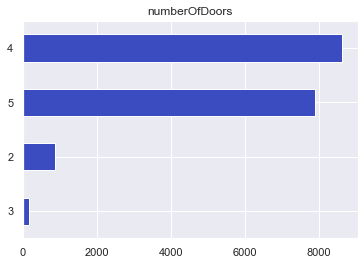

In [50]:
get_gr_counts(train, 'numberOfDoors')

Признак  numberOfDoors

5    1963
4    1594
2     244
3      36
Name: numberOfDoors, dtype: int64




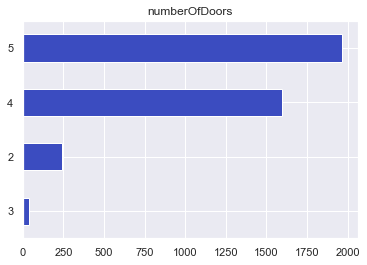

In [51]:
get_gr_counts(test, 'numberOfDoors')

**Предварительный вывод:** Обработка признака не требуется.

### Признак 'productionDate' - год производства
- Переведем в int
- По test посмотрим с каким периодом дат нам необходимо работать.
- Отфильтруем train под нужный период.
- Дальнейшие тесты показали, что скор выше, если убрать авто 2020 года выпуска из train (улучшается параметр пробега, уходят авто с пробегом 0).
- Попробовать логарифмировать признак.

In [52]:
test['productionDate'] = test['productionDate'].astype('int64')
print('Период исследования c', test['productionDate'].min(
), 'до', test['productionDate'].max(), 'год.')

Период исследования c 1981 до 2019 год.


In [53]:
train['filter_3'] = 0
test['filter_3'] = 0
train['filter_3'] = train['productionDate'].apply(
    lambda x: 1 if x < 1981 or x > 2019 else 0)
train['filter_3'].value_counts()

0    14670
1     2885
Name: filter_3, dtype: int64

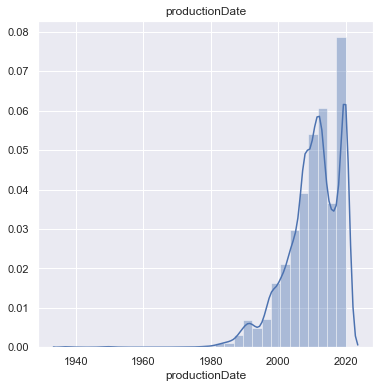

In [54]:
get_gr_num(train, 'productionDate', 30)

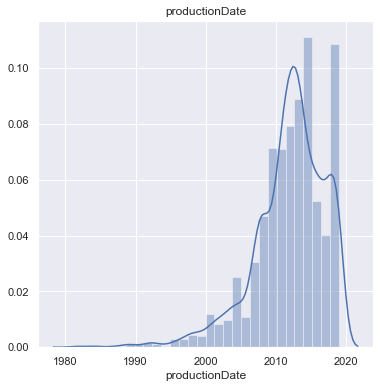

In [55]:
get_gr_num(test, 'productionDate', 30)

Удалим из train автомобили 2020 года выпуска.

In [56]:
train = train[train['productionDate'] != 2020]

### Признак 'vehicleConfiguration'

Признак  vehicleConfiguration

AUTOMATIC     12904
MECHANICAL     1678
ROBOT           128
Name: vehicleConfiguration, dtype: int64




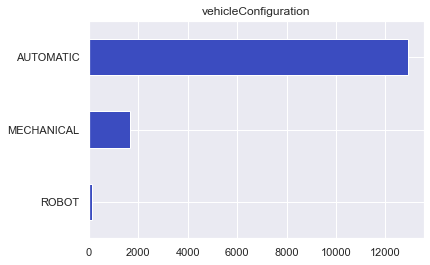

In [57]:
get_gr_counts(train, 'vehicleConfiguration')

In [58]:
test['vehicleConfiguration']

0                 SEDAN AUTOMATIC 2.0
1                 SEDAN AUTOMATIC 2.0
2                 SEDAN AUTOMATIC 4.4
3       ALLROAD_5_DOORS AUTOMATIC 3.0
4       ALLROAD_5_DOORS AUTOMATIC 3.0
                    ...              
3832              SEDAN AUTOMATIC 2.0
3833    ALLROAD_5_DOORS AUTOMATIC 3.0
3834              SEDAN AUTOMATIC 2.5
3835              SEDAN AUTOMATIC 2.0
3836    ALLROAD_5_DOORS AUTOMATIC 4.4
Name: vehicleConfiguration, Length: 3837, dtype: object

Приведем данные в test в соответствие данным в train

In [59]:
# Приводим test['vehicleConfiguration'] в соответствие с train
test['vehicleConfiguration'] = test['vehicleConfiguration'].apply(
    lambda x: 'ROBOT' if 'ROBOT' in x else 'MECHANICAL' if 'MECHANICAL' in x else 'AUTOMATIC')

### Признак 'engineDisplacement'
- В test и train разные данные в этом признаке.
- Приведем train в соответствие с test - объем двигателя.
- Переведем в int, предварительно умножив на 10, чтобы не потерять дробные части значений.

In [60]:
train['engineDisplacement'].head(3)

0    116i
1    320d
2    320i
Name: engineDisplacement, dtype: object

In [61]:
test['engineDisplacement'].head(3)

0    2.0 LTR
1    2.0 LTR
2    4.4 LTR
Name: engineDisplacement, dtype: object

In [62]:
# Обработка engineDisplacement
pattern = re.compile('\d\.\d')
train['engineDisplacement'] = train['name'].apply(lambda x: pattern.findall(x))
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: x[0] if x != [] else 0)
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: x.replace(' LTR', ''))
test['engineDisplacement'] = test['engineDisplacement'].replace('undefined', 0)

# Перевод в int
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: int(float(x)*10))
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: int(float(x)*10))

### Признак 'enginePower' - мощность двигателя
- Данные совпадают, за исключением формата.
- Приведем формат test в соответствие с train

In [63]:
train['enginePower'].head(3)

0    136
1    184
2    184
Name: enginePower, dtype: int64

In [64]:
test['enginePower'].head(3)

0    190 N12
1    150 N12
2    407 N12
Name: enginePower, dtype: object

In [65]:
# Приводим test['enginePower'] в соответствие с train
test['enginePower'] = test['enginePower'].apply(
    lambda x: int(x.replace(' N12', '')))

### Признак 'description'
- Описание автомобиля.
- Из признака можно вытащить ключевые слова, влияющие на стоимость авто.
- Обработаем после объединения test и train для создания новых признаков.

### Признак 'mileage' - пробег автомобиля
- Формат данных в train и test совпадает.
- Переведем в int

In [66]:
test['mileage'] = test['mileage'].astype('int64')

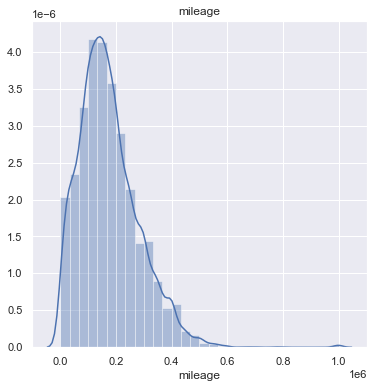

In [67]:
get_gr_num(train, 'mileage', 30)

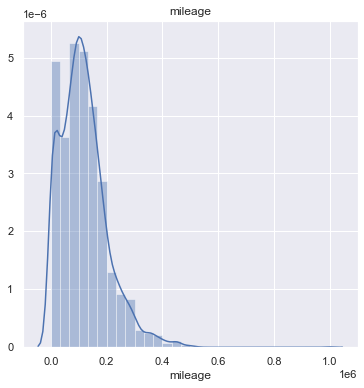

In [68]:
get_gr_num(test, 'mileage', 30)

### Признак 'Комплектация'
- В test данные идентичны данным из других признаков.
- В train очень много пропусков.
- Данный признак лучше удалить, как не несущий полезной информации. 

In [69]:
train['Комплектация'].head(3)

0    {'id': '7707468', 'name': '116i', 'available_o...
1                                          {'id': '0'}
2                                          {'id': '0'}
Name: Комплектация, dtype: object

In [70]:
test['Комплектация'].head(3)

0    ['[{"name":"Безопасность","values":["Антипробу...
1    ['[{"name":"Комфорт","values":["Круиз-контроль...
2    ['[{"name":"Комфорт","values":["Круиз-контроль...
Name: Комплектация, dtype: object

In [71]:
test = test.drop(['Комплектация'], axis=1)
train = train.drop(['Комплектация'], axis=1)

### Признак 'Привод'

Признак  Привод

полный      7341
задний      7330
передний      39
Name: Привод, dtype: int64




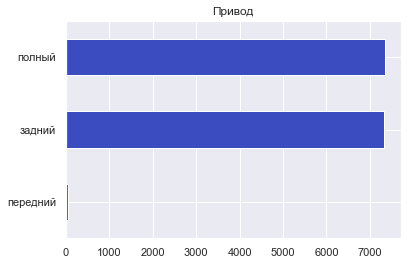

In [72]:
get_gr_counts(train, 'Привод')

Признак  Привод

полный      2444
задний      1378
передний      15
Name: Привод, dtype: int64




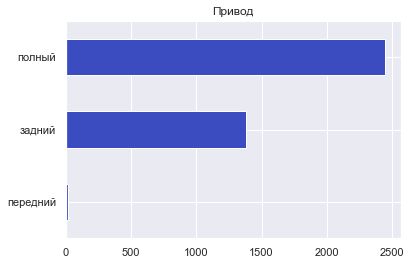

In [73]:
get_gr_counts(test, 'Привод')

**Предварительный вывод:** Данные совпадают, дополнительная обработка не требуется.

### Признак 'Руль'

Признак  Руль

LEFT     14708
RIGHT        2
Name: Руль, dtype: int64




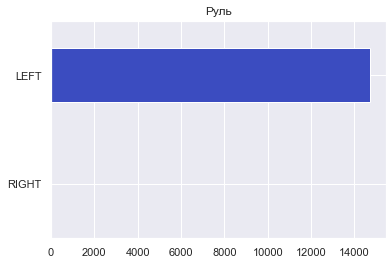

In [74]:
get_gr_counts(train, 'Руль')

Признак  Руль

Левый    3837
Name: Руль, dtype: int64




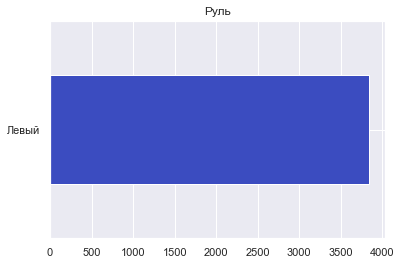

In [75]:
get_gr_counts(test, 'Руль')

В train присутствует 2 автомобиля с правым рулем, в test представлены автомобили исключительно с левым рулем.
- Удалим строки из train с автомобилями с правым рулем, т. к. они очевидно дешевле.
- Удалим данный признак, т. к. он не несет полезной информации.

In [76]:
train = train[train['Руль'] != 'RIGHT']
test = test.drop(['Руль'], axis=1)
train = train.drop(['Руль'], axis=1)

### Признак 'Владельцы'
- В train есть пропуски. В этом случае будем считать, что владелец 1
- Данные отличаются в train и test по формату.
- Приведем данные к единому формату int

Признак  Владельцы

3.0    8653
2.0    3468
1.0    2564
Name: Владельцы, dtype: int64




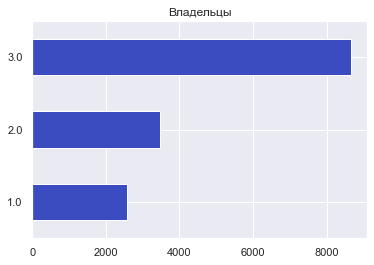

In [77]:
get_gr_counts(train, 'Владельцы')

Признак  Владельцы

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: Владельцы, dtype: int64




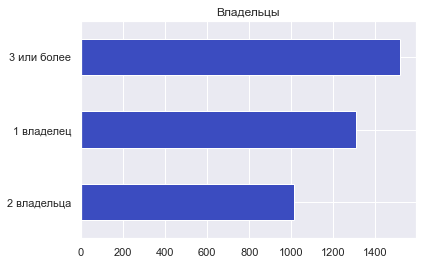

In [78]:
get_gr_counts(test, 'Владельцы')

In [79]:
# Владельцы (пропуски считаем, что владелец 1)
train['Владельцы'] = train['Владельцы'].fillna(1)
train['Владельцы'] = train['Владельцы'].astype('int64')

In [80]:
# Приводим test['Владельцы'] в соответствие с train
owners_dict = {
    '3 или более': 3,
    '1\xa0владелец': 1,
    '2\xa0владельца': 2
}

test['Владельцы'] = test['Владельцы'].replace(to_replace=owners_dict)

### Признак 'ПТС'
- В train есть пропуски. В этом случае будем считать, что ПТС Оригинал
- Данные отличаются в train и test по формату. Приведем их в соответствие друг другу.

Признак  ПТС

ORIGINAL     11799
DUPLICATE     2902
Name: ПТС, dtype: int64




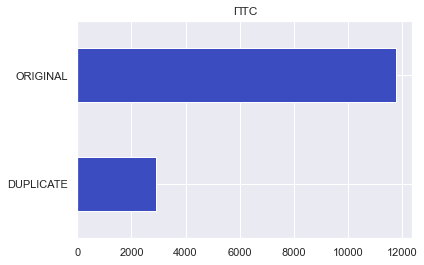

In [81]:
get_gr_counts(train, 'ПТС')

Признак  ПТС

Оригинал    3463
Дубликат     374
Name: ПТС, dtype: int64




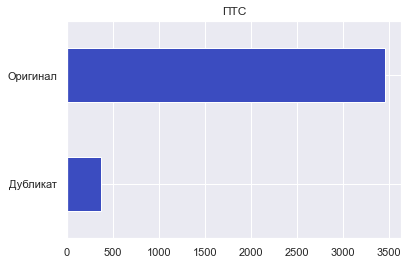

In [82]:
get_gr_counts(test, 'ПТС')

In [83]:
# ПТС (пропуски считаем, что ПТС Оригинал)
train['ПТС'] = train['ПТС'].fillna('Оригинал')

# Приводим train['ПТС'] в соответствие с test
pts_dict = {
    'ORIGINAL': 'Оригинал',
    'DUPLICATE': 'Дубликат'
}

train['ПТС'] = train['ПТС'].replace(to_replace=pts_dict)

### Признак 'Таможня'
- Все автомобили растаможены. Признак можно удалить, т. к. он не несет информации.

Признак  Таможня

True    14708
Name: Таможня, dtype: int64




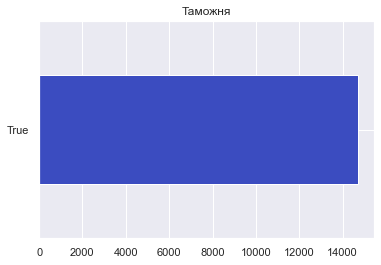

In [84]:
get_gr_counts(train, 'Таможня')

Признак  Таможня

Растаможен    3837
Name: Таможня, dtype: int64




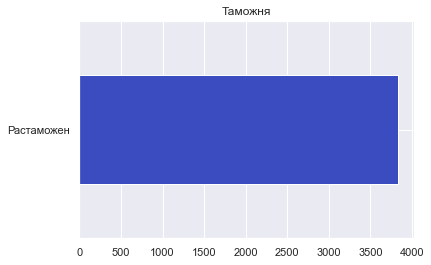

In [85]:
get_gr_counts(test, 'Таможня')

In [86]:
test = test.drop(['Таможня'], axis=1)
train = train.drop(['Таможня'], axis=1)

### Признак 'Владение'
- В train около 75% строк являются пропусками. Удалим данный параметр в дата сетах.

In [87]:
test = test.drop(['Владение'], axis=1)
train = train.drop(['Владение'], axis=1)

- Удалим признак 'name', т. к. мы взяли из него всю необходимую информацию.

In [88]:
test = test.drop(['name'], axis=1)
train = train.drop(['name'], axis=1)

### Создадим общий дата фрейм
Для упрощения создания новых признаков.
- Проверим, что датасеты имеют одинаковые наборы признаков

In [89]:
(set(test.columns) - set(train.columns)
 ) == (set(train.columns) - set(test.columns)) == set()

True

- Создадим параметр для последующего разделения дата сета на train и test.
- Создадим общий дата фрейм.

In [90]:
train['train'] = 1
test['train'] = 0
df = pd.concat([test, train])
df.head(5)

,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,description,mileage,Привод,Владельцы,ПТС,description_Nan,...,filter_1,filter_2,d_in_name,i_in_name,4WD_in_name,xDrive_in_name,xi_in_name,L_in_name,hyb_in_name,sDrive_in_name,sd_in_name,si_in_name,series,filter_3,train
0,седан,чёрный,дизель,2016,4,2017,AUTOMATIC,20,190,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836,задний,1,Оригинал,0,...,0,0,1,0,0,0,0,0,0,0,0,0,5ER,0,0
1,седан,белый,дизель,2018,4,2019,AUTOMATIC,20,150,Автомобиль из демонстрационного парка по спец ...,10,задний,1,Оригинал,0,...,0,0,1,0,0,0,0,0,0,0,0,0,3ER,0,0
2,седан,синий,бензин,2009,4,2012,AUTOMATIC,44,407,Машина собиралась под заказ! \r\n\r\n,120000,полный,2,Оригинал,0,...,0,0,0,1,1,1,0,0,0,0,0,0,5ER,0,0
3,внедорожник 5 дв.,белый,дизель,2014,5,2015,AUTOMATIC,30,249,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466,полный,2,Оригинал,0,...,0,0,1,0,1,0,0,0,0,0,0,0,X5,0,0
4,внедорожник 5 дв.,синий,дизель,2014,5,2019,AUTOMATIC,30,381,Автомобиль не имеет собственников ( физ. лиц) ...,11891,полный,1,Оригинал,0,...,0,0,1,0,1,0,0,0,0,0,0,0,X5,0,0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18545 entries, 0 to 17623
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              18545 non-null  object
 1   color                 18545 non-null  object
 2   fuelType              18545 non-null  object
 3   modelDate             18545 non-null  int64 
 4   numberOfDoors         18545 non-null  int64 
 5   productionDate        18545 non-null  int64 
 6   vehicleConfiguration  18545 non-null  object
 7   engineDisplacement    18545 non-null  int64 
 8   enginePower           18545 non-null  int64 
 9   description           18034 non-null  object
 10  mileage               18545 non-null  int64 
 11  Привод                18545 non-null  object
 12  Владельцы             18545 non-null  int64 
 13  ПТС                   18545 non-null  object
 14  description_Nan       18545 non-null  uint8 
 15  owners_Nan            18545 non-null

### Создание новых признаков
Средний пробег в год

In [92]:
df['mileage_prod_date'] = df['mileage'] / df['productionDate']
df['mileage_prod_date'] = df['mileage_prod_date'].astype('int64')

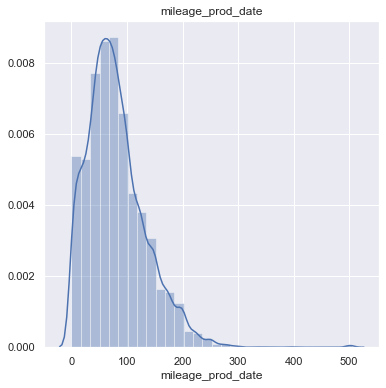

In [93]:
get_gr_num(df, 'mileage_prod_date', 30)

Пробег / кол-во владельцев (сколько владелец в среднем проезжал на авто)

In [94]:
df['mileage_owns'] = df['mileage'] / df['Владельцы']
df['mileage_owns'] = df['mileage_owns'].astype('int64')

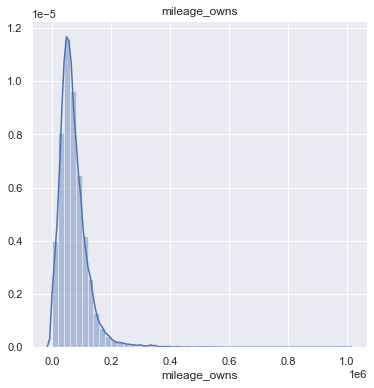

In [95]:
get_gr_num(df, 'mileage_owns', 50)

Среднее время владения автомобилем каждым владельцем.

In [96]:
df['owns_year'] = (2020-df['modelDate']) / df['Владельцы']
df['owns_year'] = df['owns_year'].astype('int64')

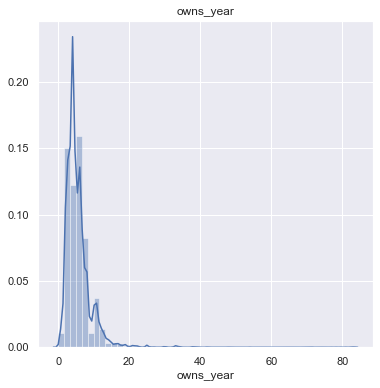

In [97]:
get_gr_num(df, 'owns_year', 50)

### Поработаем с description

In [100]:
# Фнукция работы с ключевыми словами описания
def features_from_description(df):
    # заполним пропуски в 'description'
    df['description'].fillna(' ', inplace=True)
    # разбиваем признак 'description' на наборы слов
    df['description_word'] = df['description'].apply(
        lambda x: [str(i).lower() for i in str(x).split()])
    # сделали признак с количеством слов в описании
    df['how_mach_words'] = df['description_word'].apply(lambda x: len(x))
    # каждый набор (список слов) из check_list будемформировать в демми признак
    # по принципу есть хоть что-то из списка
    check_list = [
        ['кожа', 'альконтара'],
        ['чип', 'апгрейд', 'stage'],
        ['бронир', 'плёнк', 'пленк'],
        ['круиз'],
        ['климат'],
        ['обогрев'],
        ['мультифункцион'],
        ['карбон'],
        ['доводчик'],
        ['камера'],
        ['парктро'],
        ['amg'],
        ['ксенон'],
        ['торг'],
        ['биксенон'],
        ['кредит'],
        ['ликвидация'],
        ['диски', 'литые', 'литьё'],
        ['панорам'],
        ['вмятина', 'царапина', 'замен', 'трещ',
         'брак', 'скол', 'притёрт', 'притерт'],
        ['покрашен', 'покрас'],
        ['авари', 'дтп'],
        ['сопрт', 'sport'],
        ['л.с.', 'лс', 'л. с.']
    ]

    def find_word(x, words=['кожа']):
        if len(x) > 0:
            for x_i in x:
                for w_i in words:
                    if w_i in x_i:
                        return 1
            return 0
        else:
            return 0
    k = 0
    for i in check_list:
        col_name = 'descr_' + str(k) + '_' + str(i[0])
        df[col_name] = df['description_word'].apply(find_word, i)
        k += 1

    # удаляем вспомогательную колонку
    df = df.drop(['description_word'], axis=1)

    return df


df = features_from_description(df)

Распределение признака 'how_mach_words'

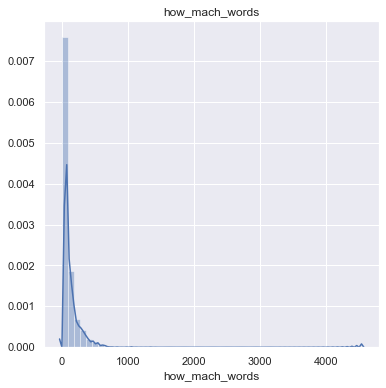

In [101]:
get_gr_num(df, 'how_mach_words', 50)

- Векторизация описания и вытаскивание из этого пары признаков

In [102]:
vectorizer = CountVectorizer(
    max_df=0.8,  # отсекаем слова, которые попадаются в 80% случаев
    min_df=0.005,  # отскеаем слова редкие, которые встречаются реже 0,5%
    max_features=1000)

text_feat = vectorizer.fit_transform(df['description'].fillna(' '))

df['mean'] = text_feat.mean(axis=1)
df['mean'] = df['mean'].apply(lambda x: int(x*1000))
df['sum'] = text_feat.sum(axis=1)

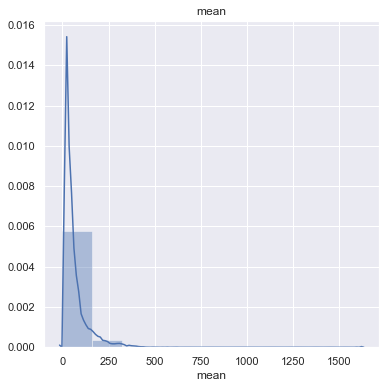

In [103]:
get_gr_num(df, 'mean', 10)

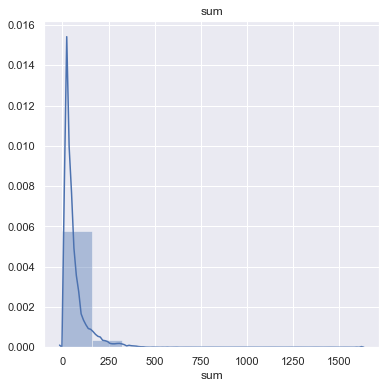

In [104]:
get_gr_num(df, 'sum', 10)

- Удалим description

In [105]:
df = df.drop(['description'], axis = 1)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18545 entries, 0 to 17623
Data columns (total 66 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   bodyType                18545 non-null  object
 1   color                   18545 non-null  object
 2   fuelType                18545 non-null  object
 3   modelDate               18545 non-null  int64 
 4   numberOfDoors           18545 non-null  int64 
 5   productionDate          18545 non-null  int64 
 6   vehicleConfiguration    18545 non-null  object
 7   engineDisplacement      18545 non-null  int64 
 8   enginePower             18545 non-null  int64 
 9   mileage                 18545 non-null  int64 
 10  Привод                  18545 non-null  object
 11  Владельцы               18545 non-null  int64 
 12  ПТС                     18545 non-null  object
 13  description_Nan         18545 non-null  uint8 
 14  owners_Nan              18545 non-null  uint8 
 15  pt

### Категориальные признаки
- Создадим список категориальных признаков для передачи списка в классификатор cat boost или для преобразования признаков в dummy-переменные в случае использования других моделей.

In [107]:
cat_cols = ['bodyType', 'color', 'fuelType',
            'vehicleConfiguration', 'Привод', 'ПТС', 'model', 'series']

### Числовые признаки
- Логарифмируем числовые признаки.

In [108]:
num_cols = ['modelDate', 'productionDate', 'mileage', 'mileage_prod_date',
            'mileage_owns', 'owns_year', 'how_mach_words', 'mean', 'sum', 'price']

## Создадим варианты дата сетов для тестирования моделей
- df_0_0_0 - наиболее полный дата сет, без удаления строк.
- df_1_1_1 - дата сет наиболее приближенный к test (удалены все строк, которые не соответствуют test).
- Остальные дата сеты - промежуточные варианты для тестирования.

In [109]:
df_0_0_0 = df.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_0_0_0, open('df_0_0_0.pkl', 'wb'))

In [110]:
df_1_1_1 = df.query('filter_1 == 0 & filter_2 == 0 & filter_3 == 0')
df_1_1_1 = df_1_1_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_1_1_1, open('df_1_1_1.pkl', 'wb'))

In [111]:
df_0_0_1 = df.query('filter_3 == 0')
df_0_0_1 = df_0_0_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_0_0_1, open('df_0_0_1.pkl', 'wb'))

In [112]:
df_0_1_0 = df.query('filter_2 == 0')
df_0_1_0 = df_0_1_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_0_1_0, open('df_0_1_0.pkl', 'wb'))

In [113]:
df_1_0_0 = df.query('filter_1 == 0')
df_1_0_0 = df_1_0_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_1_0_0, open('df_1_0_0.pkl', 'wb'))

In [114]:
df_0_1_1 = df.query('filter_2 == 0 & filter_3 == 0')
df_0_1_1 = df_0_1_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_0_1_1, open('df_0_1_1.pkl', 'wb'))

In [115]:
df_1_0_1 = df.query('filter_1 == 0 & filter_3 == 0')
df_1_0_1 = df_1_0_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_1_0_1, open('df_1_0_1.pkl', 'wb'))

In [116]:
df_1_1_0 = df.query('filter_1 == 0 & filter_2 == 0')
df_1_1_0 = df_1_1_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)
#pickle.dump(df_1_1_0, open('df_1_1_0.pkl', 'wb'))

In [117]:
# Загрузить дата фрейм можно так:
# df_0_0_0 = pickle.load(open('df_0_0_0.pkl', 'rb'))

## Stacking

снова разобьем выборку на трейн и тест

In [163]:
train = df_1_1_0[df_1_1_0.train == 1].drop('train', axis=1)
test = df_1_1_0[df_1_1_0.train == 0].drop(['train', 'price'], axis=1)

__Были испробованы следующие способы и комбинации:__

1) катбуст с гиперпараметрами по умолчанию

2) катбуст с гиперпараметрами, подобранными руками

3) случайный лес

4) катбуст и кросс-валидация

5) случайный лес и кросс-валидация

6) стекинг, при котором производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения (катбуст+случайный лес) - для обоих алгоритмов один датафрейм 

7) стекинг, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке (случайный лес+деревья)- для обоих алгоритмов один датафрейм 


8) стекинг, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке (случайный лес+катбуст)- для каждого алгоритма свой датафрейм, и этот вариант в итоге был самым эффективным. Если использовать функцию для стекинга, то надо, чтобы датафрейм был одинаковый, а для катбуста хороши текстовые фичи, но это не подходит для случайного леса.

9) стекинг, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке (случайный лес+бэггинг+катбуст)- для каждого алгоритма свой датафрейм

### Функции для стекинга

вот пример функции для стекинга, при котором производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения

In [ ]:
# Получаем из базового алгоритма фичи для мета-алгоритма
# Подаем на вход регрессор, выборки и кол-во разбиений
# Для одного (каждого) регрессора
def compute_meta_feature(rgs, X_train, X_test, y_train, cv):
    # Делаем массивы нулей, чтобы потом его заполнить значениями
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    # Разбиваем на фолды тренировочную выборку (получаем индексы)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        # Клонируем классификатор, чтобы его использовать на всех фолдах
        folded_rgs = clone(rgs)
        # если модель - это катбуст, то передаем еще несколько параметров
        # Обучаем
        if type(rgs).__name__ == 'CatBoostRegressor':
            #folded_clf.fit(X_fold_train, y_fold_train, cat_features=cat_cols, verbose_eval = 100)
            folded_rgs.fit(X_fold_train, y_fold_train, verbose_eval=100)
        else:
            folded_rgs.fit(X_fold_train, y_fold_train)
  # Предсказываем и постепенно записываем в наш массив
        # Получаем массив трейн для мета-классификатора
        X_meta_train[predict_fold_index] = folded_rgs.predict(X_fold_predict)
    # Далее на каждом шаге, где мы обучаем folded_rgs.fit (X_fold_train, y_fold_train)
    # и его предсказания на X_fold_predict запихиваем в X_meta_train[predict_fold_index]
    # добавим еще одну строку, где в X_meta_test будем добавлять предсказания вероятностей folded_cl на X_test.
    # Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить,
    # а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);
    # я выбрала вариант сразу складывать друг с другом
        X_meta_test += folded_rgs.predict(X_test)
# Предсказываем на тесте, но это будет не y_pred а X_test для мета-классификатора
# После цикла останется только усреднить все эти массивы, это и будет наш X_meta_tes.
    X_meta_test = X_meta_test / cv.n_splits
# Возвращаем тренировочную и тестовую выборки для мета-классификатора
    return X_meta_train, X_meta_test


# Функция прогоняет несколько классификаторов через предыдущую функцию и делает стекинг
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    features = [
        compute_meta_feature(rgs, X_train, X_test, y_train, cv)
        for rgs in tqdm(classifiers)
    ]

    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ], axis=-1)

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ], axis=-1)

    return stacked_features_train, stacked_features_test

In [ ]:
вот пример функции для стекинга, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке 

In [ ]:
# Получаем из базового алгоритма фичи для мета-алгоритма
# Подаем на вход регрессор, выборки и кол-во разбиений
# Для одного (каждого) регрессора
def compute_meta_feature(rgs, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.

    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    # Делаем массив нулей, чтобы потом его заполнить значениями
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    # Разбиваем на фолды тренировочную выборку (получаем индексы)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        # Клонируем классификатор, чтобы его использовать на всех фолдах
        folded_rgs = clone(rgs)
        # Обучаем
        folded_rgs.fit(X_fold_train, y_fold_train)
        # Предсказываем и постепенно записываем в наш массив
        # Получаем массив трейн для мета-классификатора
        X_meta_train[predict_fold_index] = folded_rgs.predict(X_fold_predict)

    # Получаем массив тест для мета-классификатора
    # Обучаем тот же классификатор на всей выборке трейн
    meta_rgs = clone(rgs)
    meta_rgs.fit(X_train, y_train)

    # Предсказываем на тесте, но это будет не y_pred а X_test для мета-классификатора
    X_meta_test = meta_rgs.predict(X_test)

    # Возвращаем тренировочную и тестовую выборки для мета-классификатора
    return X_meta_train, X_meta_test

In [ ]:
# Функция прогоняет несколько классификаторов через предыдущую функцию и делает стекинг
def generate_metafeatures(regressors, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.

    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(rgs, X_train, X_test, y_train,
                             cv)  # Наша предыдущая функция
        for rgs in tqdm(classifiers)
    ]

    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T
    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T

    return stacked_features_train, stacked_features_test

Как было указано выше, не получается "обернуть" стекинг в функцию из-за особенностей катбуста, поэтому будем для каждой модели сделаем все шаги отдельно

### Собственно сам стекинг

In [164]:
n_foldes = 5
cv = KFold(n_splits=n_foldes, shuffle=True, random_state=RANDOM_SEED)

X = train.drop(['price'], axis=1,)

#y = train.price.values
#ранее было отмечено, что распределение у таргета логнормальное, поэтому прологарифмируем таргет, чтобы сделать распределение нормальным
y = np.array(train.price.apply(lambda i: np.log(i)))

X_meta_train_features = []
X_meta_test_features = []

# 1 - catboost

model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          l2_leaf_reg=0.5,
                          depth=12,
                          od_type='Iter',
                          od_wait=50,
                          bootstrap_type='Bayesian',
                          bagging_temperature=0.1,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'])

X_meta_train = np.zeros_like(y, dtype=np.float32)
X_meta_test = np.zeros(len(test), dtype=np.float32)
for train_fold_index, predict_fold_index in cv.split(X):
    X_fold_train, X_fold_predict = X.iloc[train_fold_index], X.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]
    y_fold_test = y[predict_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train,
                     cat_features=cat_cols,
                     eval_set=(X_fold_predict, y_fold_test),
                     verbose_eval=500,
                     use_best_model=True,
                     plot=False
                     )
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    X_meta_test += folded_model.predict(test)


X_meta_test = X_meta_test / n_foldes

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

0:	learn: 1.6890481	test: 1.6854948	best: 1.6854948 (0)	total: 149ms	remaining: 4m 57s
500:	learn: 0.0329361	test: 0.1151352	best: 0.1151352 (500)	total: 1m 5s	remaining: 3m 16s
1000:	learn: 0.0127550	test: 0.1138583	best: 0.1138583 (1000)	total: 2m 12s	remaining: 2m 11s
1500:	learn: 0.0057567	test: 0.1130492	best: 0.1130467 (1498)	total: 3m 18s	remaining: 1m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1129951071
bestIteration = 1723

Shrink model to first 1724 iterations.
0:	learn: 1.6577321	test: 1.7661773	best: 1.7661773 (0)	total: 23.9ms	remaining: 47.8s
500:	learn: 0.0339274	test: 0.1169205	best: 0.1169118 (498)	total: 1m 5s	remaining: 3m 16s
1000:	learn: 0.0123460	test: 0.1151483	best: 0.1151483 (1000)	total: 2m 14s	remaining: 2m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1147697643
bestIteration = 1329

Shrink model to first 1330 iterations.
0:	learn: 1.6767471	test: 1.5882359	best: 1.5882359 (0)	total: 135ms	remaining: 4m 

In [165]:
# 2 - randomForestRegressor

model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

X_meta_train = np.zeros_like(y, dtype=np.float32)
X_train_num = X.drop(cat_cols, axis=1)
test_num = test.drop(cat_cols, axis=1)

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(test_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parall

собираем метафичи

In [166]:
stacked_features_train = np.vstack(X_meta_train_features).T
stacked_features_test = np.vstack(X_meta_test_features).T

В качестве метафункции были протестированы линейная регрессия, Ридж, Лассо и Эластикнет. Лучший скор у Риджа

In [167]:
# используем гридсерч для поиска гиперпараметров
rgs = Ridge()
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 0.5, 0.1, 1, 5, 10,
                        20], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid_ridge = GridSearchCV(
    estimator=rgs, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_ridge.fit(stacked_features_train, y)
grid_ridge.best_params_

{'alpha': 1e-10, 'solver': 'sag'}

In [168]:
# запихиваем подобранные гиперпараметры в модель и обучаем
rgs = Ridge(alpha=1e-10, solver='sag', random_state=RANDOM_SEED)
rgs.fit(stacked_features_train, y)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='sag', tol=0.001)

In [169]:
# предсказываем
pred = rgs.predict(stacked_features_test)
# экспоненциируем предсказанные цены, так как ранее логарфимировали
pred = np.exp(pred)

## Submission

In [170]:
sample_submission['price'] = pred

Были протестированы варианты уменьшения цены на 5, 10, 12, 13, 15, 20 процентов и округления на 1, 5, 10, 50 и 100 тыс. Лучший скор получился если итоговые предсказания умножить на 0.9 (то есть уменьшение на 10%) и потом округлить до 5 тыс.

In [171]:
# Введем понижающий коэфиициент, чтобы привести текущие цены к ценам, которые были когда создавалось соревновение
sample_submission['price'] = sample_submission['price'] * 0.9  # Минус 10%
# Округление до 5 000
sample_submission['price'] = np.round(sample_submission['price']*2, -4)/2
# сохранить в файл
sample_submission[['id', 'price']].to_csv(
    f'submission_v_staking_ridge_gr_110.csv', index=False)